# Toronto Neighbourhoods Assignment
In this assignment, we will get geographical data on Toronto neighbourhoods, then retrieve a list of venues in each neighbourhood, and cluster the neighbourhoods according to the mix of venues they contain.

First, we import the libraries we'll be using and setup some constants we need to access FourSquare.

In [1]:
import math
import time
import numpy as np
import pandas as pd
import requests
import json
import bs4
from bs4 import BeautifulSoup

import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
import arcgis
from arcgis.gis import GIS
from arcgis.geocoding import geocode

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import pixiedust   # for debugging

import sklearn
from sklearn.cluster import KMeans

# setup to get venues from FourSquare
CLIENT_ID = '45VEWB41JT1OW5HZTH0ODPBHDZMVMEZQZ4T3N1VJVRLOD2NC'
CLIENT_SECRET = 'T11YZT0HMFJ4A14S02DTKSAMF5VHUGKI5YNKXP00MWNGANW5'
VERSION = '20190401'

# setup to get businesses from Yelp
YELP_BEARER_TOKEN = 'M-PhskgPhzqATWSby4ZNlTQ0iPiGTv31l9htnwgaQurGBvsr5VPzwNwPg3VCeuHvR6LjcoGV8eEZneaY5bKZJUq3sA4vg5OgOl6E9qk2fXSAkV_ruAQxBfbpYKizXHYx'

print('pandas version ' + pd.__version__)
print('numpy version ' + np.__version__)
print('BeautifulSoup version ' + bs4.__version__)
print('matplotlib version ' + mpl.__version__)
print('Folium version ' + folium.__version__)
print('ArcGIS version' + arcgis.__version__)
print('sklearn version ' + sklearn.__version__)

Pixiedust database opened successfully


pandas version 0.23.4
numpy version 1.15.4
BeautifulSoup version 4.6.3
matplotlib version 3.0.2
Folium version 0.8.3
ArcGIS version1.6.0
sklearn version 0.20.1


Wikipedia has a list of postal code prefixes (offically called Forward Sortation Areas or FSA's) mapped to a Borough name and a Neighbourhood name. We'll scrape it for some initial labelling data.

In [74]:
# get the Toronto neighbourhoods wiki page
resp = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
body = BeautifulSoup(resp.text, 'html.parser')
#print(body.prettify())

# scrape the neighbourhood data from the page
df = pd.DataFrame(columns=['PostalCode','Borough','Neighbourhood'])
rows = []
tbl = body.find(class_='wikitable sortable')
for row in tbl.find_all('tr'):
    cell_text = []
    for cell in row.find_all('td'):
        cell_text.append(cell.get_text().rstrip())
    if len(cell_text) == 3 and cell_text[1] != 'Not assigned':
        rows.append({'PostalCode': cell_text[0], 'Borough': cell_text[1], 'Neighbourhood': cell_text[2]})
            
df = df.append(rows)

Some initial fixups are needed:
    - some neighbourhoods are listed as 'Not assigned', for these just copy the borough name.
    - some FSA's have multiple neighbourhoods, aggregate these into a sngle entry, with a comma-separated list of neighbourhoods.
    - some of the FSA's are just processing centers and don't really correspond with a geographical area - drop these.

In [76]:
# fix missing neighbourhood names
assign_missing_neighbourhood = lambda row: row['Borough'] if row['Neighbourhood'] == 'Not assigned' else row['Neighbourhood']
df['Neighbourhood'] = df.apply(assign_missing_neighbourhood, axis=1) 

# aggregate multiple neighbourhoods in a postal code
df.sort_values('PostalCode', inplace=True)
df = pd.DataFrame(df.groupby(['PostalCode','Borough'])['Neighbourhood'].agg(lambda ser: ser.str.cat(sep=',')))
df.reset_index(inplace=True)
print('DataFrame shape before dropping processing centers: ' + str(df.shape))

# drop postal processing centers
df.drop(df[df['Neighbourhood'].str.contains('Processing Centre')].index, inplace=True)
df.reset_index(drop=True, inplace=True)

# check the results
df.head()

DataFrame shape before dropping processing centers: (103, 3)


,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Port Union,Rouge Hill,Highland Creek"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [73]:
df.shape

(96, 3)

## The above is the answer for the first 'submit a link' box of the assignment - a data frame with cleaned up neighbourhood data.

## My final row count differs from the instructors due to the dropping of processing centers, which do not really represent any particular geographical area.

Use the ArcGIS geocode module to find the location of each neighbourhood. You can query it by just passing in the 3-character FSA and it will return a latitude/longitude of roughly the center of the FSA, as well as the min and max latitude/longitude that define its bounding box.

In [4]:
# Get location of each neighbourhood. The geocode module will return a bounding box for
# each neighbourhood, let's see how that looks.
gis = GIS()
locations = []
def get_location(loc):
    res = geocode(address=loc)
    locations.append([
        res[0]['location']['y'],
        res[0]['location']['x'],
        res[0]['extent']['ymin'],
        res[0]['extent']['ymax'],
        res[0]['extent']['xmin'],
        res[0]['extent']['xmax']
    ])
    
df['PostalCode'].map(lambda x: get_location(x))
loc_df = pd.DataFrame(locations, columns=['Latitude','Longitude', 'LatitudeMin', 'LatitudeMax', 'LongitudeMin', 'LongitudeMax'])
df = pd.concat([df, loc_df], axis=1)
print(df.head())
df.shape

  PostalCode      Borough                         Neighbourhood   Latitude  \
0        M1B  Scarborough                         Rouge,Malvern  43.811525   
1        M1C  Scarborough  Port Union,Rouge Hill,Highland Creek  43.785730   
2        M1E  Scarborough       Guildwood,Morningside,West Hill  43.765690   
3        M1G  Scarborough                                Woburn  43.768359   
4        M1H  Scarborough                             Cedarbrae  43.769688   

   Longitude  LatitudeMin  LatitudeMax  LongitudeMin  LongitudeMax  
0 -79.195517    43.749525    43.873525    -79.257517    -79.133517  
1 -79.158750    43.742730    43.828730    -79.201750    -79.115750  
2 -79.175256    43.715690    43.815690    -79.225256    -79.125256  
3 -79.217590    43.746359    43.790359    -79.239590    -79.195590  
4 -79.239440    43.751688    43.787688    -79.257440    -79.221440  


(101, 9)

## The above is the answer to the second 'submit a link' box on the assignment - the data frame with lat/long coordinates for each neighbourhood.

Let's map that and see how it looks so far. Playing around, I found that zoom level 11 is a good fit.

In [5]:
# get the approximate center of the data, just the midpoint between the max and min latitude/longitdue
center_lon = (df['Longitude'].max() + df['Longitude'].min()) / 2
center_lat = (df['Latitude'].max() + df['Latitude'].min()) / 2

# map neighborhoods
map = folium.Map(location=[center_lat, center_lon], zoom_start=11)
for lat, lon, lat_min, lat_max, lon_min, lon_max, borough, neighbourhood in zip(
    df['Latitude'], df['Longitude'], df['LatitudeMin'], df['LatitudeMax'], df['LongitudeMin'], df['LongitudeMax'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)
    
    folium.Rectangle(
        bounds=[[lat_min, lon_min], [lat_max, lon_max]],
        color='blue',
        weight=1,
        fill=False,
        parse_html=False
    ).add_to(map)

map

The bounding boxes from ArcGIS don't define the boundaries of the neighbourhoods very well, there's way too much overlap.

Geo data giving the boundaries of the FSA's is available from Statistics Canada:  
    https://www150.statcan.gc.ca/n1/en/catalogue/92-179-X.

Converted the .shp file to .geojson and simplified the geometry a little using ogr2ogr:  
     `ogr2ogr -f GeoJSON -simplify 100 -t_srs EPSG:4326 canada_postalcodes_100.geojson lfsa000b16a_e.shp`

We can then load the geojson file in, and remove all the non-Toronto postal codes (those not starting with 'M').


In [6]:
with open('canada_postalcodes_10.geojson', 'r') as f:
    geo = json.load(f)
newFeatures = [ feature for feature in geo['features'] if feature['properties']['CFSAUID'][0] == 'M' ]
geo['features'] = newFeatures

Let's check against our list of neighbourhoods and see if they line up

In [7]:
# check if all of our neighbourhoods are in the GeoJSON file
get_fsa = lambda f: f['properties']['CFSAUID']
geo_neighbourhoods = [ get_fsa(feature) for feature in geo['features'] ]
df.loc[ df['PostalCode'].isin(geo_neighbourhoods) == False ]

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,LatitudeMin,LatitudeMax,LongitudeMin,LongitudeMax
60,M5K,Downtown Toronto,"Toronto Dominion Centre,Design Exchange",43.647100,-79.381531,43.646100,43.648100,-79.382531,-79.380531
61,M5L,Downtown Toronto,"Commerce Court,Victoria Hotel",43.648205,-79.378793,43.647205,43.649205,-79.379793,-79.377793
69,M5W,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,43.648690,-79.385440,43.643690,43.653690,-79.390440,-79.380440
70,M5X,Downtown Toronto,"Underground city,First Canadian Place",43.648280,-79.381461,43.647280,43.649280,-79.382461,-79.380461
85,M7A,Queen's Park,Queen's Park,43.661102,-79.391035,43.656102,43.666102,-79.396035,-79.386035


Some of our neighbourhood postal codes do not appear in the GeoJSON. Reading the docs from Stats Canada, this is because 'they were not the dominant FSA in
a dissemination area':
- M5K, M5L, M5X - these are buildings in downtown Toronto, we can map them to neighbourhood M5H
- M5W - this is Postal Station A, mainly used for business reply mail - we can drop this from our neighborhoods
- M7A - Queen's Park, this is located in the M5S FSA so we'll map it to that neighbourhood



In [8]:
# we'll use this map later when we're assigning business to neighbourhoods
map_fsas = {
    'M5K': 'M5H',
    'M5L': 'M5H',
    'M5X': 'M5H',
    'M5W': None,
    'M7A': 'M5S'
}

# we can drop those FSA's from our list of neighbourhood names
df = df[ df['PostalCode'].isin(['M5K', 'M5L', 'M5X', 'M5W', 'M7A']) == False ]
df.reset_index()
df.shape


(96, 9)

OK, now let's check if all of the FSA areas in the geoJSON file appear in our neighbourhoods list.

In [9]:
for f in geo['features']:
    if not f['properties']['CFSAUID'] in list(df['PostalCode']):
        print("FSA {} is not in the neighbourhoods dataframe".format(f['properties']['CFSAUID']))

OK, so our neighbourhoods list and the geo data should be lined up nicely. Let's map that and see how it looks. We need a little workaround because there is a problem drawing complex geometries directly in the notebook if using Chrome.

In [10]:
def embed_map(m):        # workaround for complex maps in Chrome
    from IPython.display import IFrame

    m.save('index.html')
    return IFrame('index.html', width='100%', height='750px')

# create a map centered on Toronto
map = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# add a choropleth layer, just make everything light blue for now
map.choropleth(geo_data=geo, fill_color='#AED6F1', fill_opacity=0.4)

# draw a popup marker at the Wikipedia location of each neighbourhood
for lat, lng, postal_code, borough, neighbourhood in zip(
    df['Latitude'],
    df['Longitude'],
    df['PostalCode'],
    df['Borough'],
    df['Neighbourhood']
):

    label = '{}-{}, {}'.format(postal_code, neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)

# display the map
embed_map(map)

C:\Users\john\Anaconda3\lib\site-packages\folium\folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


The neighbourhood boundaries look very good, thanks StasCan!

Looking closely, we see that some of the neighbourhood locations from Wikipedia are a bit off. Let's fix them up by referring to Google maps.

In [11]:
df.loc[df['PostalCode'] == 'M3K', 'Latitude'] = 43.731051        # Wikipedia has this just north of the FSA
df.loc[df['PostalCode'] == 'M1X', 'Longitude'] = -79.233928      # Wikipedia has this too far east
df.loc[df['PostalCode'] == 'M8Z', 'Longitude'] = -79.515713      # Wikipedia has this too far west

There are a few more where the marker isn't exactly well-centered, but let's not get fussy.

Let's see if the neighbourhood bounding boxes from ArcGIS are a reasonable bounding box for the Greater Toronto Area at least.

Redraw the map and check everything looks good.

In [12]:
# get bounding box for GTA
min_lat = df['LatitudeMin'].min()
max_lat = df['LatitudeMax'].max()
min_lon = df['LongitudeMin'].min()
max_lon = df['LongitudeMax'].max()

# create a map centered on Toronto
map = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# add a choropleth layer, just make everything light blue for now
map.choropleth(geo_data=geo, fill_color='#AED6F1', fill_opacity=0.4)

# draw a popup marker at the Wikipedia location of each neighbourhood
for lat, lng, postal_code, borough, neighbourhood in zip(
    df['Latitude'],
    df['Longitude'],
    df['PostalCode'],
    df['Borough'],
    df['Neighbourhood']
):

    label = '{}-{}, {}'.format(postal_code, neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)
    
folium.Rectangle(
    bounds=[[min_lat, min_lon], [max_lat, max_lon]],
    color='blue',
    weight=1,
    fill=False,
    parse_html=False
).add_to(map)


# display the map
embed_map(map)

OK, the neighbourhoods are looking really good.

Now we can consider how we'll get venue data. Rather than assuming each neighbourhood is a small circle, we can take advantage of the fact that we defined our neighbourhoods using postal codes. So we can scan the entire city using a grid scheme, and use the mailing address of each venue returned to sort them into their proper neighbourhood.

We don't really have any use for the bounding box data we got from Wikipedia, we've already got the min and max longitude and latitude to define the boundaries of our scan. So let's drop the unnecessary columns.

Almost half of the bounding box is either north of the GTA or in Lake Ontario. Later, we can define a couple of diagonal lines to cut these areas out of our scan and reduce the number of grid cells we have to sample, allowing us to retrieve more venues per cell.

In [13]:
df.drop(columns=['LatitudeMax','LatitudeMin','LongitudeMax','LongitudeMin'], inplace=True)

Let's take a look at a city-wide sample of data from FourSquare. We're mainly interested in how many of the venues have a postal code defined in the data.

In [14]:
venues = []
offset = 0
limit = 100
while True:
    base_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ne={},{}&sw={},{}&limit={}&offset={}&llAcc=1&intent=browse'
    url = base_url.format(CLIENT_ID, CLIENT_SECRET, VERSION, max_lat, max_lon, min_lat, min_lon, limit, offset)
    res = requests.get(url).json()
    v = res['response']['groups'][0]['items']
    if len(v) == 0:
        break;
    venues.extend(v)
    offset = offset + limit

print('Venues returned - {}'.format(len(venues)))
venues[0]

Venues returned - 239


{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4df796f1aeb7da11e1a974d4',
  'name': 'SOMA chocolatemaker',
  'location': {'address': '443 King St. W',
   'lat': 43.64532829235515,
   'lng': -79.39571438648944,
   'labeledLatLngs': [{'label': 'display',
     'lat': 43.64532829235515,
     'lng': -79.39571438648944}],
   'postalCode': 'M5V 1K4',
   'cc': 'CA',
   'city': 'Toronto',
   'state': 'ON',
   'country': 'Canada',
   'formattedAddress': ['443 King St. W', 'Toronto ON M5V 1K4', 'Canada']},
  'categories': [{'id': '4bf58dd8d48988d1d0941735',
    'name': 'Dessert Shop',
    'pluralName': 'Dessert Shops',
    'shortName': 'Desserts',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/dessert_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referralId': 'e-0-4df796f1aeb7da11e1a974d4-0'}

Build a dataframe from the venues list

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

venues_df = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode']
venues_df = venues_df.loc[:, filtered_columns]

# calculate the main category for each row
venues_df['venue.categories'] = venues_df.apply(get_category_type, axis=1)

# clean column names
venues_df.columns = [col.split(".")[-1] for col in venues_df.columns]

venues_df['postalCode'].count()

181

So 181 out of 239 venues have a postal code defined, or about 75%. Not terrible, but let's check Yelp and see if it's any better.

In [16]:
yelp_venues = []
offset = 0
limit = 50
radius = 750
while True:
    yelp_base_url = 'https://api.yelp.com/v3/businesses/search?latitude={}&longitude={}&radius={}&limit={}&offset={}'
    yelp_auth = {'Authorization': 'bearer %s' % YELP_BEARER_TOKEN}
    yelp_url = yelp_base_url.format(43.650468, -79.378362, radius, limit, offset)
    res = requests.get(url=yelp_url, headers=yelp_auth).json()
    if len(res['businesses']) == 0:
        break;
    yelp_venues.extend(res['businesses'])
    offset = offset + limit
    
yelp_venues[0]

{'id': 'mZRKH9ngRY92bI_irrHq6w',
 'alias': 'richmond-station-toronto',
 'name': 'Richmond Station',
 'image_url': 'https://s3-media1.fl.yelpcdn.com/bphoto/0LXXuFVPlXFK7cegdocdBA/o.jpg',
 'is_closed': False,
 'url': 'https://www.yelp.com/biz/richmond-station-toronto?adjust_creative=ps_npsEg8L_-uj3BwlCVvg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=ps_npsEg8L_-uj3BwlCVvg',
 'review_count': 677,
 'categories': [{'alias': 'newcanadian', 'title': 'Canadian (New)'}],
 'rating': 4.5,
 'coordinates': {'latitude': 43.6513729, 'longitude': -79.379285},
 'transactions': [],
 'price': '$$$',
 'location': {'address1': '1 Richmond Street W',
  'address2': '',
  'address3': '',
  'city': 'Toronto',
  'zip_code': 'M5H 3W4',
  'country': 'CA',
  'state': 'ON',
  'display_address': ['1 Richmond Street W', 'Toronto, ON M5H 3W4', 'Canada']},
 'phone': '+16477481444',
 'display_phone': '+1 647-748-1444',
 'distance': 125.05636723169232}

In [17]:
len(yelp_venues)

896

In [18]:
def get_yelp_category(row):
    if len(row['categories']) == 0:
        return None
    else:
        return row['categories'][0]['alias']

yelp_venues_df = json_normalize(yelp_venues)
filtered_columns = ['name', 'categories', 'location.zip_code']
yelp_venues_df = yelp_venues_df.loc[:, filtered_columns]

# calculate the main category for each row
yelp_venues_df['category'] = yelp_venues_df.apply(get_yelp_category, axis=1)

# clean column names
yelp_venues_df.columns = [col.split(".")[-1] for col in yelp_venues_df.columns]

yelp_venues_df['zip_code'].count()

896

Wow, every one has a postal code. Also, since I'm thinking my final project will be business-related, the yelp dataset is probably more relevant.

The Yelp API samples a circle with a given latitude/longitude and a radius, so doing a grid-based scan will take a little geometry. The radius of 750 meters that I used for the sample looks good, since this was a very dense part of Toronto and we didn't overflow the API limit of 1000. To completely cover the area, a bit of geometry gives a spacing of 1050 meters between the center of each circle. Let's go with 1000 meters, a little overlap won't hurt since we'll use the Yelp ID to avoid duplicates.

In [19]:
print('Latitude range {} to {}, longitude range {} to {}'.format(min_lat, max_lat, min_lon, max_lon))

Latitude range 43.576870000000056 to 43.896215000000026, longitude range -79.63918134599999 to -79.11574999999993


At http://www.csgnetwork.com/degreelenllavcalc.html there is a calculator for converting degrees of latitude/longitude to meters. For Toronto's latitude, one degree of latitude is 111,100 meters and one degree of longitude is 80,600 meters. Let's see how many 'grid cells' we'll need to sample to cover the city.

In [20]:
lat_degree_in_meters = 111106
lon_degree_in_meters = 80609
lat_cells = (max_lat - min_lat) * lat_degree_in_meters / radius
lon_cells = (max_lon - min_lon) * lon_degree_in_meters / radius
print('Scan is {} lat by {} lon, total cells {}'.format(lat_cells, lon_cells, lat_cells * lon_cells))

Scan is 47.30819409332889 lat by 56.25770315962428 lon, total cells 2661.4503403203876


That's a lot of cells, our daily API limit is 5000 so we'd better cut it down a bit and be satisfied with a hopefully random sampling of venues returned from Yelp. Let's aim for 1000 cells and retrieve just the first 100 venues for each cell so we need 2000 API calls for the whole city. So let's work backward and figure out the cell spacing and the radius we need to do that.

In [21]:
ns_range = (max_lat - min_lat) * lat_degree_in_meters
ew_range = (max_lon - min_lon) * lon_degree_in_meters
spacing = math.sqrt(ns_range * ew_range / 1000)
radius = spacing * math.sqrt(2) / 2
lat_cells = math.ceil(ns_range / spacing)
lon_cells = math.ceil(ew_range / spacing)
ns_range, ew_range, spacing, radius, lat_cells, lon_cells

(35481.14556999667,
 42193.277369718206,
 1223.5464095939385,
 865.177963320327,
 29,
 35)

Looks reasonable, so we'll sample a grid of cells 29 (n-s) x 35 (e-w) with centers spaced 1223 meters apart and a radius of 865 meters. By doing a couple of tests we can discard the cells that are north of the GTA, or in the middle of Lake Ontario, so we can probably afford to get the first 200 venues from each grid cell. Because the sampling circles overlap we'll need to remove duplicates.

Let's go to google maps and get the equations of the diagonal lines we'll use to omit sampling areas that are not in the GTA. Of course, we'll assume the earth is approximately flat over the area we're interested in.

In [22]:
# the line between these points runs 1km north of the northern boundary of the GTA
top_w_lat = 43.757706
top_w_lon = -79.643114
top_e_lat = 43.864010
top_e_lon = -79.169706

# the line between these points runs 1km south of the SW corner of the GTA and the southern tip of the docklands
bot1_w_lat = 43.570103
bot1_w_lon = -79.542895
bot1_e_lat = 43.624206
bot1_e_lon = -79.347230

# the line between these points runs 1km south of the southern tip of the docklands and the SE corner of the GTA
bot2_w_lat = 43.624206
bot2_w_lon = -79.347230
bot2_e_lat = 43.781230
bot2_e_lon = -79.113266


def is_in_GTA(lat, lon):
    det = (top_e_lon - top_w_lon) * (lat - top_w_lat) - (top_e_lat - top_w_lat) * (lon - top_w_lon)
    if det > 0:
        return False
    det = (bot1_e_lon - bot1_w_lon) * (lat - bot1_w_lat) - (bot1_e_lat - bot1_w_lat) * (lon - bot1_w_lon)
    if det < 0:
        return False
    det = (bot2_e_lon - bot2_w_lon) * (lat - bot2_w_lat) - (bot2_e_lat - bot2_w_lat) * (lon - bot2_w_lon)
    if det < 0:
        return False
    return True

Let's visualise our scanning scheme and make sure the arithmetic all worked out.

In [23]:
# create a map centered on Toronto
map = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# add a choropleth layer, just make everything light blue for now
map.choropleth(geo_data=geo, fill_color='#AED6F1', fill_opacity=0.4)

# draw a popup marker at the Wikipedia location of each neighbourhood
for lat, lng, postal_code, borough, neighbourhood in zip(
    df['Latitude'],
    df['Longitude'],
    df['PostalCode'],
    df['Borough'],
    df['Neighbourhood']
):

    label = '{}-{}, {}'.format(postal_code, neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)
    
cell_count = 0
for i in range(lat_cells):
    lat = min_lat + ((i + 0.5) * spacing / lat_degree_in_meters)
    for j in range(lon_cells):
        lon = min_lon + ((j + 0.5) * spacing / lon_degree_in_meters)
        
        if is_in_GTA(lat, lon):
            color = 'green'
            cell_count = cell_count + 1
        else:
            color = 'red'
            
        folium.Circle(
            [lat, lon],
            radius,
            color=color,
            weight=1,
            fill=False,
            parse_html=False
        ).add_to(map)

print(cell_count)

# display the map
embed_map(map)


562


That's looking pretty good. It's OK to cut off part of the Island and the Leslie Street spit, there are are hardly any venues there. The cell count of 562 means we can retrieve 4 pages of 50 venues per cell and be comfortably inside Yelp's daily API limit of 5000. Many cells will have a lot less than 200 venues, so we won't need the full 4 pages for those. At a rough count we'll only sample about 50 cells that are outside of the GTA. Our cells are close-packed circles so it looks like roughly half the area will get sampled twice, but we can afford it and if Yelp is returning venues randomly, we might get some new venues the second time we sample one of the lens-shaped overlap areas.

Now that we've got the geography and geometry figured out, let's look at the Yelp category system. It's pretty deep - you can download the hierarchy from https://www.yelp.com/developers/documentation/v3/all_category_list/categories.json. Let's load it and get some basic info about the category tree.

In [24]:
categories = requests.get('https://www.yelp.com/developers/documentation/v3/all_category_list/categories.json').json()
for cat in categories:
    if len(cat['parents']) == 0:
        print('Top-level: ' + cat['alias'])
    if len(cat['parents']) > 1:
        print('Multiple parents: {} is in {}'.format(cat['alias'], cat['parents']))

Top-level: active
Top-level: arts
Top-level: auto
Top-level: beautysvc
Top-level: bicycles
Multiple parents: cosmetics is in ['shopping', 'beautysvc']
Multiple parents: deptstores is in ['shopping', 'fashion']
Top-level: education
Multiple parents: eltern_cafes is in ['restaurants', 'food']
Top-level: eventservices
Top-level: financialservices
Top-level: food
Multiple parents: galleries is in ['arts', 'shopping']
Multiple parents: hair_extensions is in ['hair', 'beautysvc']
Top-level: health
Top-level: homeservices
Multiple parents: hotels is in ['eventservices', 'hotelstravel']
Top-level: hotelstravel
Multiple parents: isps is in ['homeservices', 'professional']
Multiple parents: jazzandblues is in ['arts', 'nightlife']
Multiple parents: kiosk is in ['shopping', 'food']
Top-level: localflavor
Top-level: localservices
Top-level: massmedia
Multiple parents: medicalspa is in ['beautysvc', 'health']
Multiple parents: musicvenues is in ['arts', 'nightlife']
Top-level: nightlife
Multiple pa

The question is how to deal with the categories that have multiple parents. We can see that:
- there are not so many of them
- for the most part the parents are top-level categories
- none of the categories that appear as multiple parents, in turn have multiple parents themselves (important for building the tree below)

So I think we could go with counting such venues in both of their parent categories. The next question is how many levels deep we want to go into the hierarchy in order to build our features. So let's build the whole tree and print the count of categories at each level.

In [25]:
cat_root = { 'cat': { 'alias': 'all', 'title': 'All', 'parents': [] }, 'children': [], 'level': 0 }
cat_map = { 'all': cat_root }

def add_to_map(alias, parent_alias, cat):
    if alias in cat_map:
        return False
    if not parent_alias in cat_map:
        return False
    
    parent = cat_map[parent_alias]
    cat_map[alias] = { 'cat': cat, 'children': [], 'level': parent['level'] + 1}
    parent['children'].append(cat_map[alias])
    return True
    
while True:
    added_one = False
    for cat in categories:
        if len(cat['parents']) == 0:
            cat['parents'] = [ 'all' ]
        if len(cat['parents']) > 1:
            for i in range(0, len(cat['parents'])):
                added_one = add_to_map("{}_{}".format(cat['alias'], i+1), cat['parents'][i], cat) or added_one
        else:
            added_one = add_to_map(cat['alias'], cat['parents'][0], cat) or added_one
            
    if not added_one:
        break
        
nodes_at_level = [0] * 10
leaf_nodes_at_level = [0] * 10
aliases_at_level = [[] for i in range(10)]
for cat_name, cat in cat_map.items():
    aliases_at_level[cat['level']].append(cat['cat']['alias'])
    nodes_at_level[cat['level']] = nodes_at_level[cat['level']] + 1
    if len(cat['children']) == 0:
        leaf_nodes_at_level[cat['level']] = leaf_nodes_at_level[cat['level']] + 1
for i in range(0,10):
    print(i, nodes_at_level[i], leaf_nodes_at_level[i], aliases_at_level[i][0:5])
    
        

0 1 0 ['all']
1 22 0 ['active', 'arts', 'auto', 'beautysvc', 'bicycles']
2 1008 923 ['airsoft', 'amateursportsteams', 'amusementparks', 'aquariums', 'archery']
3 525 515 ['carwindowtinting', 'diyautoshop', 'freediving', 'funfair', 'generalfestivals']
4 18 18 ['intervaltraininggyms', 'muaythai', 'taekwondo', 'apartmentagents', 'brazilianjiujitsu']
5 0 0 []
6 0 0 []
7 0 0 []
8 0 0 []
9 0 0 []


So we have 22 top-level categories and 1008 at the second level. A thousand is a lot of features, let's just go with the top level categories for the purposes of the assignment.

Scan through the categories again, this time building sets containing the top-level category aliases for each category.

In [26]:
cat_alias_map = { 'all': set() }
top_categories = set()

def add_to_alias_map(alias, parents):
    if alias in cat_alias_map:
        return False
    for p in parents:
        if p not in cat_alias_map:
            return False     # wait until all parents are added before we add children
    
    parent_categories = set()
    for p in parents:
        parent_categories = parent_categories.union(cat_alias_map[p])
    if len(parent_categories) == 0:
        parent_categories.add(alias)
        top_categories.add(alias)
                           
    cat_alias_map[alias] = parent_categories
    return True

while True:
    added_one = False
    for cat in categories:
        added_one = add_to_alias_map(cat['alias'], cat['parents']) or added_one
    if not added_one:
        break
        
del cat_alias_map['all']
list(top_categories).sort()
len(cat_alias_map)

1565

OK, we can get set up to do the scan. I'll scan into a python structure and dump it to avoid having to retrieve the data again in case I'm rerunning the notebook later. The 'businesses' set is to detect duplicate venues returned from the scan.

In [30]:
businesses = set()
categories_by_postalcode = {}
for postalcode in df['PostalCode']:
    categories_row = {}
    for cat in top_categories:
        categories_row[cat] = 0
    categories_by_postalcode[postalcode] = categories_row

And we're ready to do the scan. Let's space out the queries to the API 1 second apart to avoid getting throttled.

In [31]:
limit = 200
postal_codes = df['PostalCode'].values
for i in range(lat_cells):
    lat = min_lat + ((i + 0.5) * spacing / lat_degree_in_meters)
    for j in range(lon_cells):
        lon = min_lon + ((j + 0.5) * spacing / lon_degree_in_meters)
        
        if is_in_GTA(lat, lon):
            offset = 0
            total = 1000
            while offset < limit and offset < total:
                while True:
                    yelp_base_url = 'https://api.yelp.com/v3/businesses/search?latitude={}&longitude={}&radius={}&limit=50&offset={}'
                    yelp_auth = {'Authorization': 'bearer %s' % YELP_BEARER_TOKEN}
                    yelp_url = yelp_base_url.format(lat, lon, int(radius), offset)

                    res = requests.get(url=yelp_url, headers=yelp_auth).json()
                    if 'error' in res and res['error']['code'] == 'TOO_MANY_REQUESTS_PER_SECOND':
                        time.sleep(5)
                    else:
                        break
                    
                if 'error' in res:
                    print('Yelp API returned error: ' + json.dumps(res))
                    
                if 'total' in res:
                    total = res['total']
                offset = offset + 50
                time.sleep(1)

                # scan through the businesses returned from the API
                if 'businesses' in res:
                    for bus in res['businesses']:
                        # if it doesn't have a postal code, or the postal code doesn't match one in our data frame, then skip it
                        if 'location' in bus and 'zip_code' in bus['location']:
                            # get the fsa from the postal code, and map it if needed
                            fsa = bus['location']['zip_code'][0:3]
                            if fsa in map_fsas:
                                fsa = map_fsas[fsa]
                                
                            if fsa in postal_codes:
                                # check if we've seen this business before
                                if bus['id'] not in businesses:
                                    businesses.add(bus['id'])
                                    
                                    # all good, so add the top-level categories corresponding  to the business categories to our DF
                                    for cat in bus['categories']:
                                        for alias in cat_alias_map[cat['alias']]:
                                            categories_by_postalcode[fsa][alias] = categories_by_postalcode[fsa][alias] + 1
                                    
# whew, let's save that so we may never need to do it again!
with open('categories_by_postalcode.json', 'w') as f:
    json.dump(categories_by_postalcode, f)

Convert the category counts structure to a dataframe with index=postalcode. Set the index of our neighbourhodds dataframe to the postalcode column as well so they line up. Then we can append the category counts to our neighbourhoods DF. Finally, add a column to total all the venue categories seen in a neighbourhood and reset the index so we can use PostalCode as a column.

In [36]:
cat_df = pd.DataFrame(categories_by_postalcode).T
neighbourhood_df = df.set_index('PostalCode')
combined_df = pd.concat([neighbourhood_df, cat_df], axis=1)
combined_df['Total'] = combined_df.loc[:,'active':].sum(axis=1)
combined_df.reset_index(inplace=True)

print(combined_df.shape)
combined_df.head()

(96, 28)


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,active,arts,auto,beautysvc,bicycles,...,localservices,massmedia,nightlife,pets,professional,publicservicesgovt,religiousorgs,restaurants,shopping,Total
0,M1B,Scarborough,"Rouge,Malvern",43.811525,-79.195517,4,0,0,0,0,...,0,0,4,0,0,0,0,105,0,131
1,M1C,Scarborough,"Port Union,Rouge Hill,Highland Creek",43.785730,-79.158750,3,0,0,0,0,...,0,0,1,0,0,0,0,35,0,44
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.765690,-79.175256,2,0,0,0,0,...,0,0,7,0,0,0,0,79,0,96
3,M1G,Scarborough,Woburn,43.768359,-79.217590,1,0,0,0,0,...,0,0,1,0,0,0,0,17,0,20
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440,0,0,0,0,0,...,0,0,6,0,0,0,0,98,0,129


That looks to have worked - lets map the total categories we found per neighbourhood and check it looks reasonable.

In [37]:
# create a map centered on Toronto
map = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# add a choropleth layer, just make everything light blue for now
map.choropleth(geo_data=geo, data=combined_df, columns=['PostalCode', 'Total'], key_on='properties.CFSAUID', fill_color='YlGn', fill_opacity=0.6)

# draw a popup marker at the Wikipedia location of each neighbourhood
for lat, lng, postal_code, borough, neighbourhood, total in zip(
    combined_df['Latitude'],
    combined_df['Longitude'],
    combined_df['PostalCode'],
    combined_df['Borough'],
    combined_df['Neighbourhood'],
    combined_df['Total']
):

    label = '{}-{}, {} ({})'.format(postal_code, neighbourhood, borough, total)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)

# display the map
embed_map(map)

Well, that looks pretty reasonable. Finally time to do some clustering. We can work with the cat_df dataframe, whose columns are just the counts of each venue category in the neighbourhood. Normalise so the values in each row add up to 1.

In [47]:
cat_df = cat_df.div(cat_df.sum(axis=1), axis=0)
cat_df.head()

,active,arts,auto,beautysvc,bicycles,education,eventservices,financialservices,food,health,...,localflavor,localservices,massmedia,nightlife,pets,professional,publicservicesgovt,religiousorgs,restaurants,shopping
M1B,0.030534,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.137405,0.0,...,0.0,0.0,0.0,0.030534,0.0,0.0,0.0,0.0,0.801527,0.0
M1C,0.068182,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.113636,0.0,...,0.0,0.0,0.0,0.022727,0.0,0.0,0.0,0.0,0.795455,0.0
M1E,0.020833,0.0,0.0,0.0,0.0,0.0,0.010417,0.0,0.072917,0.0,...,0.0,0.0,0.0,0.072917,0.0,0.0,0.0,0.0,0.822917,0.0
M1G,0.050000,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.050000,0.0,0.0,0.0,0.0,0.850000,0.0
M1H,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.193798,0.0,...,0.0,0.0,0.0,0.046512,0.0,0.0,0.0,0.0,0.759690,0.0


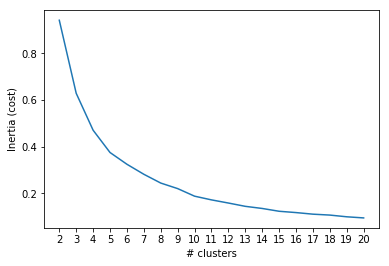

In [55]:
# find a good k-value
inertia = []
for k in range(2,21):
    kmm = KMeans(init='k-means++', n_clusters=k, n_init=12)
    kmm.fit(cat_df)
    inertia.append(kmm.inertia_)

plt.plot(range(2,21), inertia)
plt.xticks(range(2,21))
plt.ylabel('Inertia (cost)')
plt.xlabel('# clusters')
plt.show()
    

Usual problem with k-means, hard to pick a best value for k. Anything between 7 and 11 looks reasonable. Let's go with 7 to keep it simple. Rerun the model, and add the labels to the combined DF.

In [60]:
kmm = KMeans(init='k-means++', n_clusters=7, n_init=12)
kmm.fit(cat_df)
cat_df['Type'] = kmm.labels_

combined_df.set_index('PostalCode', inplace=True)
combined_df = pd.concat([combined_df, cat_df['Type']], axis=1)
combined_df.reset_index(inplace=True)
combined_df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,active,arts,auto,beautysvc,bicycles,...,massmedia,nightlife,pets,professional,publicservicesgovt,religiousorgs,restaurants,shopping,Total,Type
0,M1B,Scarborough,"Rouge,Malvern",43.811525,-79.195517,4,0,0,0,0,...,0,4,0,0,0,0,105,0,131,0
1,M1C,Scarborough,"Port Union,Rouge Hill,Highland Creek",43.785730,-79.158750,3,0,0,0,0,...,0,1,0,0,0,0,35,0,44,2
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.765690,-79.175256,2,0,0,0,0,...,0,7,0,0,0,0,79,0,96,6
3,M1G,Scarborough,Woburn,43.768359,-79.217590,1,0,0,0,0,...,0,1,0,0,0,0,17,0,20,3
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440,0,0,0,0,0,...,0,6,0,0,0,0,98,0,129,3


And now we can map the result!!

In [71]:
# create a map centered on Toronto
map = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# add a choropleth layer, just make everything light blue for now
map.choropleth(
    geo_data=geo,
    data=combined_df,
    columns=['PostalCode', 'Type'],
    key_on='properties.CFSAUID',
    fill_color='Set3',
    bins=np.arange(-0.5,7.5,1.0),
    legend_name='Neighbourhood Type',
    fill_opacity=0.6)

# draw a popup marker at the Wikipedia location of each neighbourhood
for lat, lng, postal_code, borough, neighbourhood in zip(
    combined_df['Latitude'],
    combined_df['Longitude'],
    combined_df['PostalCode'],
    combined_df['Borough'],
    combined_df['Neighbourhood']
):

    label = '{}-{}, {}'.format(postal_code, neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)

# display the map
embed_map(map)

Apologies for the poor legend labelling, but this is about the best Folium can do at the moment.

So to this point, I think the assignment has been satisfied. Next steps are to use this clustering to create a useful application

PS: I notice that when pushed to GitHub, none of the maps are displaying :( So I added snapshots of each one to the repo. Apologies that you can't play around with them.